In [11]:
from systemml import MLContext, dml, jvm_stdout
ml = MLContext(sc)
ml.version()

u'1.0.0-SNAPSHOT'

In [18]:
script="""
source("nn/layers/cross_entropy_loss.dml") as cross_entropy_loss
source("nn/layers/l2_loss.dml") as l2_loss

source("nn/layers/lstm.dml") as lstm
source("nn/layers/sigmoid.dml") as sigmoid

source("nn/optim/sgd_nesterov.dml") as sgd_nesterov
source("nn/optim/rmsprop.dml") as rmsprop

X = seq(0, 999, 1) * 3.14 / 100 #0 to 10 pi radians

X = sin(X)
#print(toString(X))

in_TS = 75 #in_TS
out_TS = 25 #out_TS
N = nrow(X) / (in_TS + out_TS)
M = out_TS

idx_mat = outer(seq(0,N-1,1), t(seq(0,in_TS+out_TS-1,1)), "+") + 1
#print(toString(idx_mat))

idx_col = matrix(idx_mat, rows=nrow(idx_mat)*ncol(idx_mat), cols=1)
rordrd_X = table(seq(1, nrow(idx_col), 1), idx_col, nrow(idx_col), nrow(idx_col)) %*% X

X = matrix(rordrd_X, rows=nrow(idx_mat), cols=ncol(idx_mat))
#print(toString(X))

Y = X[,in_TS+1:in_TS+out_TS]
X = X[,1:in_TS]

max_iterations = 2000
iter = 0
learningRate = 0.01
decayRate = 0.95

[W, b, out0, c0] = lstm::init(N,1,M)
rmspropCache = rmsprop::init(W)

while( iter < max_iterations ){
    [a1, c, c_out, c_c, c_ifog] = lstm::forward(X, W, b, in_TS, 1, FALSE, out0, c0)
    loss = l2_loss::forward(a1, Y)

    if(iter %% 100 == 0) print("iter=" + iter + " loss=" + loss)

    loss_grad = l2_loss::backward(a1, Y)
    [dX, dW, db, dout0, dc0] = lstm::backward(loss_grad, c0, X, W, b, in_TS, 1, FALSE, out0, c0, c_out, c_c, c_ifog)

    [W, rmspropCache] = rmsprop::update(W, dW, learningRate, decayRate, 1e-6, rmspropCache)

    iter = iter + 1
}

[a1, c, c_out, c_c, c_ifog] = lstm::forward(X, W, b, in_TS, 1, FALSE, out0, c0)
print(toString(cbind(a1, Y)))

"""

In [19]:
prog = dml(script).output("a1").output("X").output("Y")
with jvm_stdout(True):
    result = ml.execute(prog)

iter=0 loss=1.482576498588268
iter=100 loss=0.1612714328013795
iter=200 loss=0.058938287626221386
iter=300 loss=0.04897157601036786
iter=400 loss=0.031392670989147206
iter=500 loss=0.03271373060275306
iter=600 loss=0.029034160789182445
iter=700 loss=0.0377526211023614
iter=800 loss=0.009473446532038406
iter=900 loss=0.021804000351799663
iter=1000 loss=0.032295088972713305
iter=1100 loss=0.016885715019442922
iter=1200 loss=0.032142600672863356
iter=1300 loss=0.011399926950937665
iter=1400 loss=0.009869723200786508
iter=1500 loss=0.014297125319484428
iter=1600 loss=0.015026303897219703
iter=1700 loss=0.010265573574590854
iter=1800 loss=0.16290252619536108
iter=1900 loss=0.0019342772124357182
0.701 0.670 0.657 0.628 0.607 0.592 0.557 0.541 0.504 0.478 0.449 0.431 0.392 0.361 0.335 0.302 0.289 0.247 0.235 0.204 0.143 0.164 0.134 0.084 -0.010 0.708 0.685 0.662 0.638 0.614 0.589 0.563 0.537 0.510 0.483 0.455 0.427 0.398 0.369 0.340 0.310 0.280 0.250 0.220 0.189 0.158 0.127 0.096 0.064 0.033


In [20]:
X = result.get("X").toNumPy()
a1 = result.get("a1").toNumPy()

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
complete = np.vstack((np.transpose(X),np.transpose(a1)))

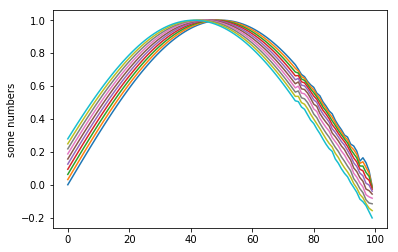

In [23]:
plt.plot(complete)
plt.ylabel('some numbers')
plt.show()